# Correntes médias da maré de toda a simulação

In [1]:
import pooch

url = "https://github.com/LaPoGeoMar/Proj_Modelagem_Pellet/releases/download"
version = "v0.1.0"

fname = pooch.retrieve(
    url=f"{url}/{version}/model_tides_only.nc4",
    known_hash="sha256:b6941a8e4cf158790d899e00e644d6c6a6dcaf28128623467699e5a3b23417cd",
)

In [2]:
import cf_xarray

print(cf_xarray.__version__)

import xarray as xr

ds = xr.open_dataset(fname)
ds

0.8.4


<xarray.Dataset>
Dimensions:     (m: 138, n: 218, time: 8772)
Coordinates:
    Layer       float32 ...
    latitude    (m, n) float32 ...
    longitude   (m, n) float32 ...
  * m           (m) float32 -48.87 -48.87 -48.86 -48.85 ... -47.53 -47.52 -47.51
  * n           (n) float32 -28.62 -28.62 -28.61 -28.6 ... -26.48 -26.47 -26.47
  * time        (time) datetime64[ns] 2021-01-01 ... 2022-01-01
Data variables:
    velocity_x  (time, m, n) float32 ...
    velocity_y  (time, m, n) float32 ...
    waterlevel  (time, m, n) float32 ...
Attributes: (12/25)
    title:                         NetCDF created from NEFIS-file trim-sc_fl_...
    institution:                   
    source:                        Delft3D trim file
    history:                       Wed Mar 15 14:42:40 2023: ncks -4 -L 1 mod...
    references:                    http://svn.oss.deltares.nl
    email:                         
    ...                            ...
    geospatial_lon_units:          dergees_east
    geospatial_vertical_min:       2.2039968967437744
    geospatial_vertical_max:       547.0967407226562
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  down
    NCO:                           netCDF Operators version 5.1.5 (Homepage =...

Médias

In [3]:
avg = ds.mean(dim="time")
avg.cf

Coordinates:
             CF Axes:   X: ['longitude', 'm']
                        Y: ['latitude', 'n']
                        Z: ['Layer']
                        T: n/a

      CF Coordinates:   longitude: ['longitude', 'm']
                        latitude: ['latitude', 'n']
                        vertical: ['Layer']
                        time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   latitude: ['latitude', 'n']
                        longitude: ['longitude', 'm']
                        ocean_sigma_coordinate: ['Layer']

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

Salva arquivo para simulações.

In [4]:
avg.to_netcdf("tidal_avg.nc")

In [5]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER


def creat_map(projection=ccrs.PlateCarree(), figsize=(9, 9), bbox=None):
    fig, ax = plt.subplots(
        figsize=figsize,
        subplot_kw={
            "projection": projection,
        },
    )
    if bbox:
        ax.set_extent(bbox)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [6]:
import numpy as np


def normalize_speed(u, v):
    u_norm = u / np.sqrt(u**2.0 + v**2.0)
    v_norm = v / np.sqrt(u**2.0 + v**2.0)
    speed = (u**2 + v**2) ** 0.5
    return (u_norm, v_norm, speed)

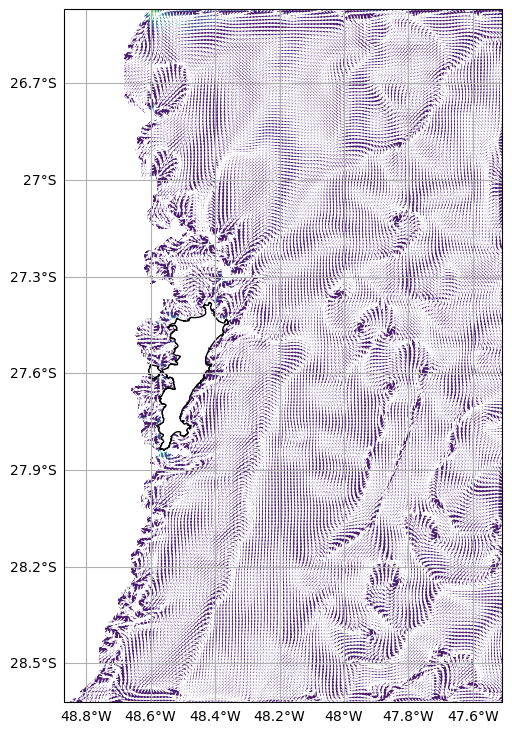

In [7]:
import geopandas

gdf = geopandas.read_file("data/floripa.geojson")
geom = gdf["geometry"].squeeze()

bbox = avg["m"].min(), avg["m"].max(), avg["n"].min(), avg["n"].max()
bbox = [v.to_numpy() for v in bbox]


u = avg["velocity_x"].squeeze()
v = avg["velocity_y"].squeeze()

u_norm, v_norm, speed = normalize_speed(u, v)

fig, ax = creat_map(bbox=bbox)
ax.contourf(avg["longitude"], avg["latitude"], speed)

ax.add_geometries([geom], ccrs.PlateCarree(), edgecolor="black", facecolor="none")
ax.quiver(avg["longitude"], avg["latitude"], u_norm, v_norm, color="white", scale=50);